In [12]:
!git clone https://github.com/xserra/audio-coding-materials.git
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft
import IPython.display as ipd
from scipy.io.wavfile import read
device = 'cpu'

fatal: destination path 'audio-coding-materials' already exists and is not an empty directory.


In [17]:
# functions used in the whole lab
def read_sound(file):
  """ read a mono wav sound file, assuming is mono, and convert it to a floating point array
    Args:
      file (str): File name
    Returns:
      sound_array (numpy.array): Array of samples as floating point values between -1 and 1
      sampling_rate (int): Sampling rate
  """
  # read sound file
  sampling_rate, x = read(file)
  # convert to floating point values between -1 and 1, assuming x are 16 bit integers
  sound_array = np.float32(x) / 2**15
  return sound_array, sampling_rate

def display_sound(sound_array, sampling_rate=44100):
  """ Display signal sound_array
    Args:
      sound_array (numpy.array): Array of samples
      sampling_rate (int): Sampling rate
  """
  # plot the waveform of the sound
  plt.figure(0, figsize=(10, 4))
  time_indexes = np.arange(0, sound_array.size/sampling_rate, 1.0/sampling_rate)
  plt.plot(time_indexes, sound_array)
  plt.xlabel('time (seconds)')
  plt.ylabel('amplitude')
  plt.show()
  # play the sound
  ipd.display(ipd.Audio(data=sound_array, rate=sampling_rate))

def display_spectrum(sound_array, sampling_rate=44100):
  """ Display magnitude spectrum of signal sound_array
    Args:
      sound_array (numpy.array): Array of samples
      sampling_rate (int): Sampling rate
  """
  # compute the spectrum of the windowed input signal
  spectrum = fft(sound_array)
  # compute the magnitude spectrum in dB
  magnitude_spectrum = 20*np.log10(abs(spectrum[:spectrum.size//2]))

  # plot the magnitude spectrum
  plt.figure(0, figsize=(10, 5))
  plt.plot(magnitude_spectrum)
  plt.ylabel('amplitude (dB)')
  plt.show()

def signal2pytorch(x):
    #Function to convert a signal vector x into a 3-d Tensor that conv1d of Pytorch expects
    #Argument x: a 1-d signal as numpy array
    #input x[batch,sample]
    #output: 3-d Tensor X for conv1d input.
    #for conv1d Input: (N,Cin,Lin), Cin: numer of input channels (e.g. for stereo), Lin: length of signal, N: number of Batches (signals)
    X = np.expand_dims(x, axis=0)  #add channels dimension (here only 1 channel)
    if len(x.shape)==1: #mono:
        X = np.expand_dims(X, axis=0)  #add batch dimension (here only 1 batch)
    X=torch.from_numpy(X)
    X=X.type(torch.Tensor)
    X=X.permute(1,0,2)  #make batch dimension first
    return X

In [21]:
# define model graph

class Convautoenc(nn.Module):
    def __init__(self):
        super(Convautoenc, self).__init__()
        # Analysis Filterbank with downsampling of N=1024, filter length of 2N, but only N/2 outputs:
        self.conv1=nn.Conv1d(in_channels=1, out_channels=32, kernel_size=2048, stride=1024, padding=1023, bias=True) #Padding for 'same' filters (kernel_size/2-1)

        #Synthesis filter bank, deconvolution
        self.synconv1=nn.ConvTranspose1d(in_channels=32, out_channels=1, kernel_size=2048, stride=1024, padding=1023, bias=True)

    def encoder(self, x):
        # pass the input signal through the convolutional layer
        x = self.conv1(x)
        # use the tanh activation function
        y = torch.tanh(x)
        return y

    def decoder(self, y):
        # Synthesis
        xrek= self.synconv1(y)
        return xrek

    def forward(self, x):
        y=self.encoder(x)
        xrek=self.decoder(y)
        return xrek

In [22]:
# read training data
batch=1
audio1, samplerate = read_sound("/content/audio-coding-materials/162095-chinese-orchestra-channel-1.wav")
X_train = signal2pytorch(audio1).to(device)
display_sound(audio1, samplerate)

Output hidden; open in https://colab.research.google.com to view.

In [23]:
# Generate Model
model = Convautoenc().to(device)
print('Total number of parameters: %i' % (sum(p.numel() for p in model.parameters() if p.requires_grad)))
# loss function used is Mean Square Error
loss_fn = nn.MSELoss()

Ypred = model(X_train)

# length of the signal at the output of the network.
outputlen = len(Ypred[0,0,:])
print("outputlen=", outputlen)

# the target signal with same length as model output
Y=X_train[:,:,:outputlen]

print("Input X.shape =", X_train.shape)
print("Target Y.shape =", Y.shape)
print("Target Y =", Y)
print("Y.type() =", Y.type())

Total number of parameters: 131105
outputlen= 873474
Input X.shape = torch.Size([1, 1, 874006])
Target Y.shape = torch.Size([1, 1, 873474])
Target Y = tensor([[[-0.0003, -0.0003, -0.0003,  ..., -0.0068, -0.0069, -0.0069]]])
Y.type() = torch.FloatTensor


In [25]:
# train model
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Ypred = model(X_train)
print("Ypred=", Ypred)

# train the model over a number of epochs
nepocs = 2000
for epoch in range(nepocs):
  Ypred=model(X_train)
  loss=loss_fn(Ypred, Y)
  if epoch%10==0:
    print(epoch, loss.item())
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

Ypred= tensor([[[-0.0015, -0.0003,  0.0008,  ..., -0.0041, -0.0059, -0.0055]]],
       grad_fn=<ConvolutionBackward0>)
0 0.0015770124737173319
10 0.0015101868193596601
20 0.0014501899713650346
30 0.0013953398447483778
40 0.001344549935311079
50 0.0012970857787877321
60 0.0012524675112217665
70 0.001210379647091031
80 0.0011706060031428933
90 0.0011329898843541741
100 0.0010974050965160131
110 0.0010637396480888128
120 0.0010318885324522853
130 0.001001753262244165
140 0.0009732483304105699
150 0.0009463048190809786
160 0.0009208739502355456
170 0.0008969251648522913
180 0.0008744361693970859
190 0.0008533835061825812
200 0.0008337310282513499
210 0.0008154259412549436
220 0.0007984011899679899
230 0.0007825809880159795
240 0.0007678887341171503
250 0.0007542513776570559
260 0.0007416015141643584
270 0.000729876512195915
280 0.0007190168253146112
290 0.0007089654682204127
300 0.0006996664451435208
310 0.0006910648080520332
320 0.0006831070058979094
330 0.0006757412920705974
340 0.000668

ww= OrderedDict([('conv1.weight', tensor([[[ 0.0203, -0.0204, -0.0089,  ..., -0.0111, -0.0203,  0.0171]],

        [[ 0.0182,  0.0187, -0.0059,  ...,  0.0135, -0.0019,  0.0215]],

        [[ 0.0040,  0.0208,  0.0053,  ...,  0.0053,  0.0016, -0.0183]],

        ...,

        [[ 0.0039,  0.0139, -0.0075,  ...,  0.0118,  0.0060,  0.0200]],

        [[ 0.0023, -0.0060,  0.0011,  ..., -0.0115,  0.0044,  0.0131]],

        [[ 0.0202, -0.0171, -0.0081,  ..., -0.0168,  0.0029, -0.0208]]])), ('conv1.bias', tensor([-0.0083,  0.0202,  0.0052, -0.0034, -0.0121,  0.0168, -0.0075, -0.0212,
        -0.0180, -0.0085,  0.0141,  0.0203, -0.0010, -0.0137, -0.0199, -0.0012,
        -0.0013,  0.0170,  0.0104,  0.0082, -0.0032,  0.0085,  0.0171,  0.0108,
         0.0201,  0.0087, -0.0102, -0.0032, -0.0220,  0.0152, -0.0002,  0.0203])), ('synconv1.weight', tensor([[[ 0.0035,  0.0150,  0.0197,  ..., -0.0127, -0.0127, -0.0186]],

        [[ 0.0068,  0.0217,  0.0219,  ...,  0.0217, -0.0118, -0.0097]],

        

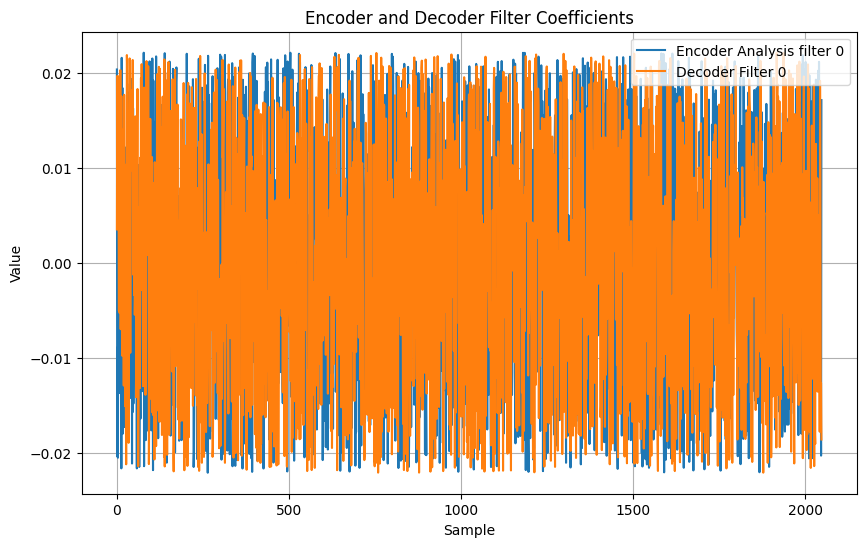

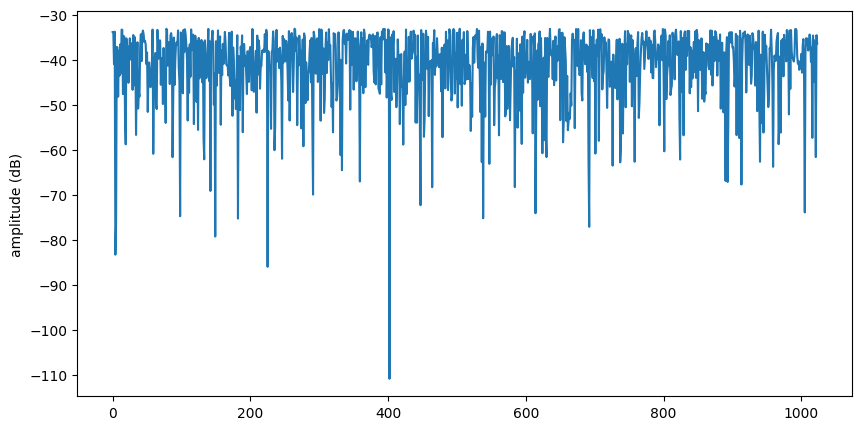

predictions.shape= (1, 1, 873474)


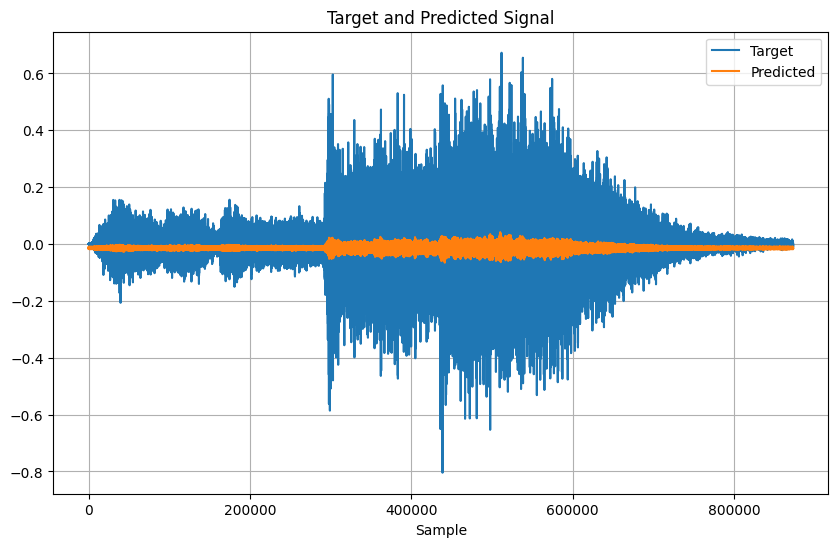

In [19]:
# make predictions using the training set

#read obtained weights
ww = model.state_dict()
print("ww=", ww)

#Plot obtained weights:
plt.figure(figsize=(10,6))
plt.plot(np.transpose(np.array(ww['conv1.weight'][0:1,0,:])))
plt.plot(np.transpose(np.array(ww['synconv1.weight'][0:1,0,:])))
plt.legend(('Encoder Analysis filter 0', 'Decoder Filter 0'))
plt.xlabel('Sample')
plt.ylabel('Value')
plt.title('Encoder and Decoder Filter Coefficients')
plt.grid()

display_spectrum(np.transpose(np.array(ww['conv1.weight'][0:1,0,:])), 44100)


# Make Predictions based on the obtained weights, on training set
predictions = model(X_train).cpu()
predictions = predictions.detach()
predictions = np.array(predictions)
Y=np.array(Y) #target
print("predictions.shape=", predictions.shape)
#Plot target signal and output of autoencoder:
plt.figure(figsize=(10,6))
plt.plot(np.array(Y[0,0,:]))
plt.plot(predictions[0,0,:])
plt.legend(('Target','Predicted'))
plt.title('Target and Predicted Signal')
plt.xlabel('Sample')
plt.grid()
#remove unnecessary dimension for playback
xrek=predictions[:,0,:]

In [ ]:
# play input and predicted sounds
display(ipd.Audio(audio1, rate=samplerate))
display(ipd.Audio(xrek, rate=samplerate))

Output hidden; open in https://colab.research.google.com to view.

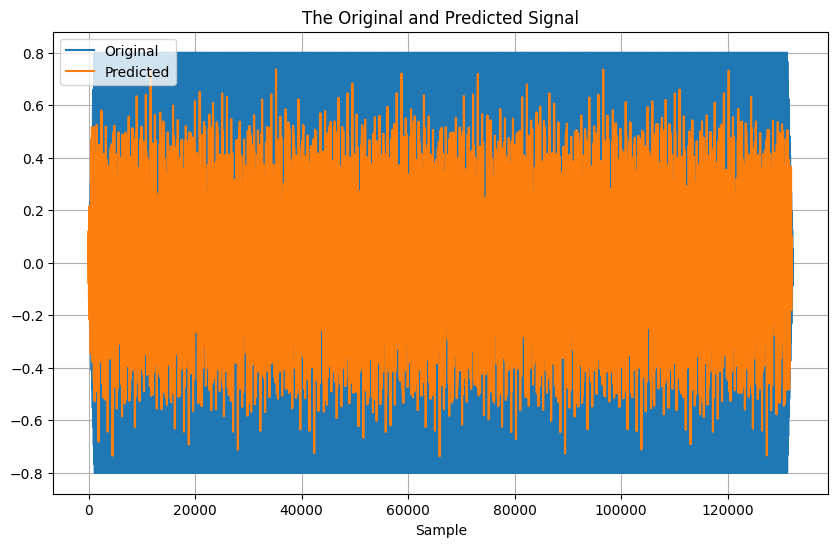

In [ ]:
#Test on data different from the training one

# audio2, samplerate = read_sound("/content/audio-coding-materials/162095-chinese-orchestra-channel-2.wav")
audio2, samplerate = read_sound("/content/audio-coding-materials/sinewave.wav")
X_test=signal2pytorch(audio2).to(device) #Convert to pytorch format, batch is first dimension

# Make Predictions based on the obtained weights, on verification set
predictions = model(X_test).cpu()
predictions = predictions.detach()
predictions = np.array(predictions)
plt.figure(figsize=(10,6))
plt.plot(np.array(X_test[0,0,:]))
plt.plot(predictions[0,0,:])
plt.legend(('Original','Predicted'))
plt.title('The Original and Predicted Signal')
plt.xlabel('Sample')
plt.grid()
xrek=predictions[:,0,:]

In [ ]:
#play input and predicted sound
display(ipd.Audio(audio2, rate=samplerate))
display(ipd.Audio(xrek, rate=samplerate))

In [ ]:
!pip install torchviz
from torchviz import make_dot

# Define the Convautoenc model
class Convautoenc(nn.Module):
    def __init__(self):
        super(Convautoenc, self).__init__()
        # Analysis Filterbank with downsampling
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=2048, stride=1024, padding=1023, bias=True)

        # Synthesis filter bank
        self.synconv1 = nn.ConvTranspose1d(in_channels=32, out_channels=1, kernel_size=2048, stride=1024, padding=1023, bias=True)

    def encoder(self, x):
        # Analysis
        x = self.conv1(x)
        y = torch.tanh(x)
        return y

    def decoder(self, y):
        # Synthesis
        xrek = self.synconv1(y)
        return xrek

    def forward(self, x):
        y = self.encoder(x)
        xrek = self.decoder(y)
        return xrek

# Create model and dummy input
model = Convautoenc()
x = torch.randn(1, 1, 8192)  # Dummy input (batch_size=1, channels=1, sequence_length=8192)

# Forward pass to create the graph
y = model(x)

# Generate and visualize the computation graph
graph = make_dot(y, params=dict(list(model.named_parameters())))

# Save the graph to a file
graph.render("convautoenc_model_plot", format="png")


  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4132 sha256=c99e58841bdfc5e3b4609bb4749b828ce72a740ddca12ddb0a6be7f4a6c546af
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz


'convautoenc_model_plot.png'